In [164]:
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import os
import csv

In [165]:
def load_dataset(dataset_dir):
        data = []
        labels = []
        class_dirs = os.listdir(dataset_dir)
        class_dict = {cls: i for i, cls in enumerate(class_dirs)}

        for cls in class_dirs:
            class_dir = os.path.join(dataset_dir, cls)
            class_label = class_dict[cls]

            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)

                image = Image.open(image_path).convert("L")
                image = image.resize((32, 32)) 
                image = np.array(image) 
                data.append(image)
                labels.append(class_label)

        data = np.array(data)
        data = data/255
        labels = np.array(labels)

        return data, labels

In [166]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [167]:
def model1(lr):
    model = keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [168]:
def model2(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [169]:
def model3(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [170]:
def model4(lr):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPool2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

In [171]:
def plot_risks_matrix(model, risks):
    # Organizza i dati in una matrice
    risks_matrix = np.array(risks).reshape(len(learning_rates), len(batch_size))

    fig, ax = plt.subplots()

    # Valori sugli assi
    ax.set_xticks(np.arange(len(learning_rates)))
    ax.set_yticks(np.arange(len(batch_size)))
    ax.set_xticklabels(learning_rates)
    ax.set_yticklabels(batch_size)

    # Etichette sugli assi
    plt.xlabel("Learning Rate")
    plt.ylabel("Batch Size")
    plt.title(f"{model.__name__} - Risks for Different Learning Rates and Batch Sizes")

    for i in range(len(learning_rates)):
        for j in range(len(batch_size)):
            text = ax.text(j, i, f"{risks_matrix[i, j]:.4f}", ha="center", va="center", color="w")

    im = ax.imshow(risks_matrix, cmap="coolwarm", aspect='auto')
    
    vmin, vmax = risks_matrix.min(), risks_matrix.max()
    im.set_clim(vmin, vmax)

    plt.colorbar(im)
    
    plt.savefig(f'graph/{model.__name__}_risks.png')
    plt.show()

In [172]:
def plot_training_validation_loss(model, mean_train_losses, mean_val_losses):
    
    x_labels = [f'LR={lr}, BS={bs}' for bs in batch_size for lr in learning_rates]
    x_values = np.arange(len(x_labels))

    # Create the bar plot
    plt.figure(figsize=(13, 3))  # Optional: Adjust the figure size
    bar_width = 0.2

    for i in range(len(learning_rates) * len(batch_size)):
        label = x_labels[i]
        plt.bar(x_values[i] - bar_width/2, mean_train_losses[i],
                width=bar_width, label=f'Training ({label})', color='blue')
        plt.bar(x_values[i] + bar_width/2, mean_val_losses[i],
                width=bar_width, label=f'Validation ({label})', color='orange')
        
        plt.text(x_values[i] - bar_width/2, max(mean_train_losses[i], mean_val_losses[i]) + 0.02, f'{mean_train_losses[i]:.2f}', ha='center', color='blue')
        plt.text(x_values[i] + bar_width/2, max(mean_train_losses[i], mean_val_losses[i]) + 0.02, f'{mean_val_losses[i]:.2f}', ha='center', color='orange')


    plt.xticks(x_values, x_labels, rotation = 30, ha='center')  # Label with LR and BS values with rotation
    plt.ylabel('Mean Score')
    plt.title(f'{model.__name__} - Mean Training and Validation Loss for Different Hyperparameters')
    plt.ylim(0, 1)  # Adjust the y-axis limits as needed
    #plt.legend()
    plt.tight_layout()  # Optional: Adjusts subplot parameters for a better layout
    plt.savefig(f'graph/{model.__name__}_loss.png')
    plt.show()

In [173]:
def cross_val(model, X, Y, batch_size, learning_rate, patience):
    
    print(f"{model.__name__} batch_size: {batch_size} learning_rate: {learning_rate}")
    
    scores = []
    zero_one_losses = []
    train_loss = []
    val_loss = []
    
    epochs = []
    train_data = []
    val_data = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    splits = skf.split(X, Y)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

        
    with tf.device('/gpu:0'):
        for fold, (train_index, val_index) in enumerate(splits):

            train_data = X[train_index]
            train_labels = Y[train_index]
            val_data = X[val_index]
            val_labels = Y[val_index]

            print(f"Fold {fold+1}/5")
            actual_model = model(learning_rate)
            history = actual_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=[early_stopping], batch_size = batch_size, epochs = 50, verbose=1)
            #score = actual_model.evaluate(val_data, val_labels)
            best_epoch = np.argmin(history.history["val_loss"])
            
            train_loss.append(history.history["loss"][best_epoch])
            val_loss.append(history.history["val_loss"][best_epoch])
            zero_one_loss = 1 - history.history["val_accuracy"][best_epoch]
    
            zero_one_losses.append(zero_one_loss)
        
            epochs.append(best_epoch)

    train_loss_mean = np.mean(train_loss)
    val_loss_mean = np.mean(val_loss)
    risk = np.mean(zero_one_losses)
    epochs_mean = np.mean(epochs)
    print(f"risk estimate: {risk}")
    
    return train_loss_mean, val_loss_mean, risk, epochs_mean

In [191]:
def hyperparameter_test_cross_validation(model): 
    risks = []
    mean_train_losses = []
    mean_val_losses = []
    mean_epochs = []
    
    for b in batch_size:
        for lr in learning_rates:
            mean_train_loss, mean_val_loss, risk, epoch_mean = cross_val(model, X, Y, b, lr, patience)
            f = open("result/result.txt", "a")
            f.write(f"{model.__name__} epochs mean:{epochs_mean} learning rate:{lr} batch size: {b} risk: {risk}\n")
            f.close()
            risks.append(risk)
            mean_train_losses.append(mean_train_loss)
            mean_val_losses.append(mean_val_loss)
            mean_epochs.append(epoch_mean) 
            
    
    with open(f'result/{model.__name__}_risks.pkl', 'wb') as file:
        pickle.dump(risks , file)
    
    with open(f'result/{model.__name__}_val.pkl', 'wb') as file:
        pickle.dump(mean_val_losses , file)

    with open(f'result/{model.__name__}_train.pkl', 'wb') as file:
        pickle.dump(mean_train_losses , file)

    return mean_train_losses, mean_val_losses, risks, mean_epochs

In [187]:
def write_csv(models, risks, epochs):
    if os.path.exists("result/result.csv"):
        os.remove("result/result.csv")
    # Creare un file CSV e scrivere i risultati
    with open("result/result.csv", mode="w", newline="") as csv_file:
        fieldnames = ["Model", "Learning Rate", "Batch Size", "Epochs Mean", "Risk"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=';')
        writer.writeheader()

        for i in range(len(batch_size)):
            for j in range(len(learning_rates)):
                for m in range(len(models)):
                    model_name = models[m].__name__
                    epochs_mean = epochs[m][i * len(batch_size) + j]  # Calcola il valore corrispondente alle epoche medie
                    lr = learning_rates[j]
                    bs = batch_size[i]
                    risk = risks[m][i * len(batch_size) + j]

                writer.writerow({"Model": model_name, "Learning Rate": lr, "Batch Size": bs, "Epochs Mean": epochs_mean, "Risk": risk})


In [175]:
learning_rates = [0.01, 0.001, 0.0001]
batch_size = [32, 128, 256]
patience = 5

In [176]:
X, Y = load_dataset("data/dataset")
if os.path.exists("result/result.txt"):
    os.remove("result/result.txt")

In [177]:
model1_train, model1_val, model1_risks, model1_epochs = hyperparameter_test_cross_validation(model1)

model1 batch_size: 32 learning_rate: 0.01
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 10ms/step - loss: 1.3201 - accuracy: 0.5204 - val_loss: 0.6761 - val_accuracy: 0.5490
Epoch 2/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6895 - accuracy: 0.5305 - val_loss: 0.6853 - val_accuracy: 0.5600
Epoch 3/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6804 - accuracy: 0.5559 - val_loss: 0.6829 - val_accuracy: 0.6073
Epoch 4/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6852 - accuracy: 0.5392 - val_loss: 0.6830 - val_accuracy: 0.5405
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.5407 - val_loss: 0.6834 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 2s 10ms/step - loss: 0.6786 - accuracy: 0.5407 - val_loss: 0.6817 - val_accuracy: 0.5405
Fold 2/5
Epoch 1/50
148/148 [==============================] - 2s 12ms/step - loss: 1.5100 - ac

Epoch 4/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.5406 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 5/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6899 - accuracy: 0.5410 - val_loss: 0.6899 - val_accuracy: 0.5402
Epoch 6/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6912 - accuracy: 0.5406 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 7/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 8/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 9/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6901 - accuracy: 0.5408 - val_loss: 0.6902 - val_accuracy: 0.5402
Epoch 10/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6906 - accuracy: 0.5408 - val_loss: 0.6919 - val_accuracy: 0.5402
risk 

148/148 [==============================] - 2s 11ms/step - loss: 0.5472 - accuracy: 0.7191 - val_loss: 0.6033 - val_accuracy: 0.6534
Epoch 16/50
148/148 [==============================] - 2s 10ms/step - loss: 0.5553 - accuracy: 0.7127 - val_loss: 0.6146 - val_accuracy: 0.6399
Epoch 17/50
148/148 [==============================] - 2s 10ms/step - loss: 0.5423 - accuracy: 0.7207 - val_loss: 0.6060 - val_accuracy: 0.6602
Epoch 18/50
148/148 [==============================] - 2s 11ms/step - loss: 0.5411 - accuracy: 0.7201 - val_loss: 0.6116 - val_accuracy: 0.6543
Epoch 19/50
148/148 [==============================] - 2s 10ms/step - loss: 0.5254 - accuracy: 0.7366 - val_loss: 0.6833 - val_accuracy: 0.6196
Epoch 20/50
148/148 [==============================] - 2s 11ms/step - loss: 0.5301 - accuracy: 0.7298 - val_loss: 0.6713 - val_accuracy: 0.6374
Fold 4/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6833 - accuracy: 0.5703 - val_loss: 0.6827 - val_accuracy: 0.5

148/148 [==============================] - 2s 10ms/step - loss: 0.4797 - accuracy: 0.7701 - val_loss: 0.5333 - val_accuracy: 0.7348
Epoch 10/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4446 - accuracy: 0.7894 - val_loss: 0.5412 - val_accuracy: 0.7382
Epoch 11/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4300 - accuracy: 0.8056 - val_loss: 0.7376 - val_accuracy: 0.6495
Epoch 12/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4132 - accuracy: 0.8168 - val_loss: 0.5401 - val_accuracy: 0.7306
Epoch 13/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3877 - accuracy: 0.8265 - val_loss: 0.5578 - val_accuracy: 0.7432
Epoch 14/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3683 - accuracy: 0.8354 - val_loss: 0.5546 - val_accuracy: 0.7255
Fold 3/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6656 - accuracy: 0.5794 - val_loss: 0.6410 - val_accuracy: 0.6

37/37 [==============================] - 0s 12ms/step - loss: 0.6443 - accuracy: 0.6207 - val_loss: 0.6425 - val_accuracy: 0.6343
Epoch 8/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6541 - accuracy: 0.6207 - val_loss: 0.6549 - val_accuracy: 0.6284
Epoch 9/50
37/37 [==============================] - 0s 13ms/step - loss: 0.6412 - accuracy: 0.6381 - val_loss: 0.6209 - val_accuracy: 0.6630
Epoch 10/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6187 - accuracy: 0.6497 - val_loss: 0.6292 - val_accuracy: 0.6512
Epoch 11/50
37/37 [==============================] - 0s 13ms/step - loss: 0.6184 - accuracy: 0.6575 - val_loss: 0.6369 - val_accuracy: 0.6529
Epoch 12/50
37/37 [==============================] - 0s 13ms/step - loss: 0.6173 - accuracy: 0.6560 - val_loss: 0.6188 - val_accuracy: 0.6579
Epoch 13/50
37/37 [==============================] - 0s 13ms/step - loss: 0.5986 - accuracy: 0.6708 - val_loss: 0.6310 - val_accuracy: 0.6360
Epoch 14/50
37/37 [=

Epoch 18/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5755 - accuracy: 0.7024 - val_loss: 0.6129 - val_accuracy: 0.6568
Epoch 19/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5716 - accuracy: 0.7060 - val_loss: 0.6151 - val_accuracy: 0.6551
Epoch 20/50
37/37 [==============================] - 0s 10ms/step - loss: 0.5671 - accuracy: 0.7142 - val_loss: 0.6223 - val_accuracy: 0.6475
Epoch 21/50
37/37 [==============================] - 0s 10ms/step - loss: 0.5781 - accuracy: 0.6960 - val_loss: 0.6685 - val_accuracy: 0.6145
Epoch 22/50
37/37 [==============================] - 0s 10ms/step - loss: 0.5819 - accuracy: 0.6956 - val_loss: 0.6402 - val_accuracy: 0.6264
Epoch 23/50
37/37 [==============================] - 0s 10ms/step - loss: 0.5740 - accuracy: 0.7064 - val_loss: 0.6740 - val_accuracy: 0.6162
Fold 4/5
Epoch 1/50
37/37 [==============================] - 2s 26ms/step - loss: 3.2196 - accuracy: 0.5245 - val_loss: 0.6873 - val_accuracy: 0.541

37/37 [==============================] - 0s 11ms/step - loss: 0.6118 - accuracy: 0.6569 - val_loss: 0.6080 - val_accuracy: 0.6605
Epoch 7/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6146 - accuracy: 0.6499 - val_loss: 0.6259 - val_accuracy: 0.6132
Epoch 8/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6102 - accuracy: 0.6510 - val_loss: 0.6105 - val_accuracy: 0.6630
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5999 - accuracy: 0.6702 - val_loss: 0.6082 - val_accuracy: 0.6605
Epoch 10/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6066 - accuracy: 0.6624 - val_loss: 0.6105 - val_accuracy: 0.6596
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5849 - accuracy: 0.6858 - val_loss: 0.5986 - val_accuracy: 0.6655
Epoch 12/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5836 - accuracy: 0.6820 - val_loss: 0.5929 - val_accuracy: 0.6630
Epoch 13/50
37/37 [==

37/37 [==============================] - 0s 10ms/step - loss: 0.5092 - accuracy: 0.7509 - val_loss: 0.6211 - val_accuracy: 0.6520
Epoch 9/50
37/37 [==============================] - 0s 10ms/step - loss: 0.5046 - accuracy: 0.7498 - val_loss: 0.5529 - val_accuracy: 0.7154
Epoch 10/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4753 - accuracy: 0.7733 - val_loss: 0.5279 - val_accuracy: 0.7407
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4432 - accuracy: 0.7934 - val_loss: 0.5296 - val_accuracy: 0.7466
Epoch 12/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4332 - accuracy: 0.8029 - val_loss: 0.5056 - val_accuracy: 0.7660
Epoch 13/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4190 - accuracy: 0.8107 - val_loss: 0.5682 - val_accuracy: 0.7069
Epoch 14/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3988 - accuracy: 0.8223 - val_loss: 0.5057 - val_accuracy: 0.7618
Epoch 15/50
37/37 [

Epoch 15/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3916 - accuracy: 0.8291 - val_loss: 0.5324 - val_accuracy: 0.7405
Epoch 16/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3884 - accuracy: 0.8257 - val_loss: 0.5184 - val_accuracy: 0.7489
Epoch 17/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3767 - accuracy: 0.8350 - val_loss: 0.5231 - val_accuracy: 0.7371
Epoch 18/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3302 - accuracy: 0.8680 - val_loss: 0.5189 - val_accuracy: 0.7540
Epoch 19/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3098 - accuracy: 0.8735 - val_loss: 0.5324 - val_accuracy: 0.7422
Epoch 20/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3124 - accuracy: 0.8676 - val_loss: 0.5792 - val_accuracy: 0.7295
Epoch 21/50
37/37 [==============================] - 0s 10ms/step - loss: 0.2697 - accuracy: 0.8923 - val_loss: 0.5613 - val_accuracy: 0.7489
Fold 5

19/19 [==============================] - 0s 11ms/step - loss: 0.6303 - accuracy: 0.6370 - val_loss: 0.6292 - val_accuracy: 0.6275
Epoch 8/50
19/19 [==============================] - 0s 12ms/step - loss: 0.6296 - accuracy: 0.6459 - val_loss: 0.6594 - val_accuracy: 0.6056
Epoch 9/50
19/19 [==============================] - 0s 12ms/step - loss: 0.6175 - accuracy: 0.6556 - val_loss: 0.6230 - val_accuracy: 0.6571
Epoch 10/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5988 - accuracy: 0.6708 - val_loss: 0.6129 - val_accuracy: 0.6655
Epoch 11/50
19/19 [==============================] - 0s 12ms/step - loss: 0.5879 - accuracy: 0.6803 - val_loss: 0.6241 - val_accuracy: 0.6562
Epoch 12/50
19/19 [==============================] - 0s 12ms/step - loss: 0.5988 - accuracy: 0.6691 - val_loss: 0.6316 - val_accuracy: 0.6672
Epoch 13/50
19/19 [==============================] - 0s 12ms/step - loss: 0.6232 - accuracy: 0.6440 - val_loss: 0.6294 - val_accuracy: 0.6014
Epoch 14/50
19/19 [=

Epoch 9/50
19/19 [==============================] - 0s 12ms/step - loss: 0.6036 - accuracy: 0.6584 - val_loss: 0.6053 - val_accuracy: 0.6712
Epoch 10/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5986 - accuracy: 0.6707 - val_loss: 0.6122 - val_accuracy: 0.6391
Epoch 11/50
19/19 [==============================] - 0s 12ms/step - loss: 0.6089 - accuracy: 0.6586 - val_loss: 0.6201 - val_accuracy: 0.6636
Epoch 12/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6344 - accuracy: 0.6458 - val_loss: 0.6316 - val_accuracy: 0.6331
risk estimate: 0.33530818223953246
model1 batch_size: 256 learning_rate: 0.001
Fold 1/5
Epoch 1/50
19/19 [==============================] - 1s 24ms/step - loss: 0.7381 - accuracy: 0.5282 - val_loss: 0.7068 - val_accuracy: 0.4730
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6789 - accuracy: 0.5504 - val_loss: 0.7472 - val_accuracy: 0.4823
Epoch 3/50
19/19 [==============================] - 0s 13ms/ste

19/19 [==============================] - 0s 13ms/step - loss: 0.5929 - accuracy: 0.6789 - val_loss: 0.6270 - val_accuracy: 0.6467
Epoch 11/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5913 - accuracy: 0.6726 - val_loss: 0.6107 - val_accuracy: 0.6526
Epoch 12/50
19/19 [==============================] - 0s 11ms/step - loss: 0.5911 - accuracy: 0.6755 - val_loss: 0.6326 - val_accuracy: 0.6221
Epoch 13/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5865 - accuracy: 0.6800 - val_loss: 0.5989 - val_accuracy: 0.6779
Epoch 14/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5767 - accuracy: 0.6907 - val_loss: 0.6196 - val_accuracy: 0.6399
Epoch 15/50
19/19 [==============================] - 0s 12ms/step - loss: 0.5692 - accuracy: 0.6933 - val_loss: 0.6818 - val_accuracy: 0.6010
Epoch 16/50
19/19 [==============================] - 0s 12ms/step - loss: 0.5793 - accuracy: 0.6929 - val_loss: 0.6214 - val_accuracy: 0.6636
Epoch 17/50
19/19 

19/19 [==============================] - 0s 13ms/step - loss: 0.3416 - accuracy: 0.8591 - val_loss: 0.5326 - val_accuracy: 0.7483
Fold 3/5
Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.6689 - accuracy: 0.5801 - val_loss: 0.6551 - val_accuracy: 0.6036
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6327 - accuracy: 0.6373 - val_loss: 0.6364 - val_accuracy: 0.6112
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6047 - accuracy: 0.6777 - val_loss: 0.6158 - val_accuracy: 0.6255
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5830 - accuracy: 0.6867 - val_loss: 0.5970 - val_accuracy: 0.6602
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5588 - accuracy: 0.7216 - val_loss: 0.5924 - val_accuracy: 0.6653
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5577 - accuracy: 0.7112 - val_loss: 0.5896 - val_accuracy: 0.6610
Epoch 7/50
19/1

Epoch 19/50
19/19 [==============================] - 0s 12ms/step - loss: 0.3693 - accuracy: 0.8384 - val_loss: 0.5433 - val_accuracy: 0.7481
Epoch 20/50
19/19 [==============================] - 0s 12ms/step - loss: 0.3331 - accuracy: 0.8682 - val_loss: 0.5243 - val_accuracy: 0.7473
Epoch 21/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3148 - accuracy: 0.8754 - val_loss: 0.5320 - val_accuracy: 0.7430
Epoch 22/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3082 - accuracy: 0.8743 - val_loss: 0.5275 - val_accuracy: 0.7540
risk estimate: 0.25638035535812376


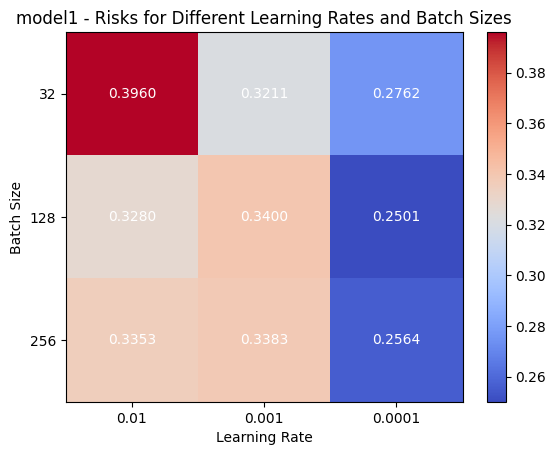

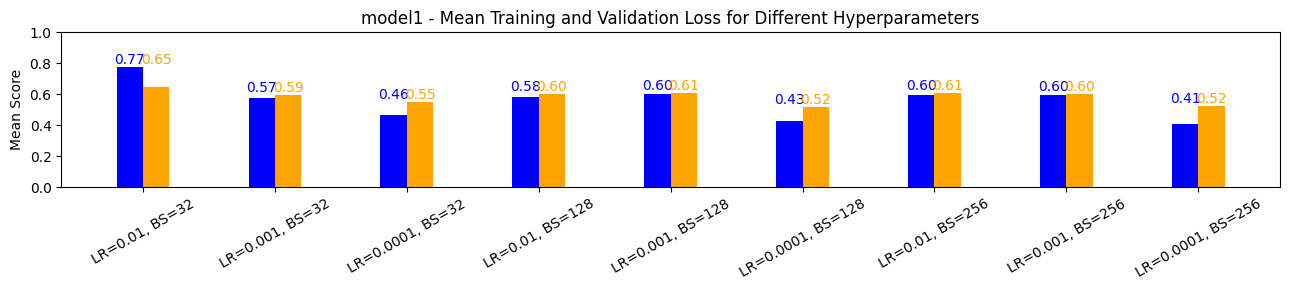

In [178]:
plot_risks_matrix(model1, model1_risks)
plot_training_validation_loss(model1, model1_train, model1_val)

In [179]:
model2_trian, model2_val, model2_risks, model2_epochs = hyperparameter_test_cross_validation(model2)

model2 batch_size: 32 learning_rate: 0.01
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 10ms/step - loss: 0.6943 - accuracy: 0.5339 - val_loss: 0.6925 - val_accuracy: 0.5405
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.5375 - val_loss: 0.6911 - val_accuracy: 0.5405
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6912 - accuracy: 0.5383 - val_loss: 0.6910 - val_accuracy: 0.5405
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6905 - accuracy: 0.5407 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6903 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6901 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 7/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6903 - accuracy: 0.5

Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6903 - val_accuracy: 0.5402
Epoch 7/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6903 - accuracy: 0.5408 - val_loss: 0.6899 - val_accuracy: 0.5402
risk estimate: 0.41218616962432864
model2 batch_size: 32 learning_rate: 0.001
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.5959 - accuracy: 0.6761 - val_loss: 0.5171 - val_accuracy: 0.7517
Epoch 2/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4910 - accuracy: 0.7678 - val_loss: 0.4772 - val_accuracy: 0.7711
Epoch 3/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.7921 - val_loss: 0.4401 - val_accuracy: 0.7872
Epoch 4/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4240 - accuracy: 0.8050 - val_loss: 0.4205 - val_accuracy: 0.8083
Epoch 5/50
148/148 [==============================] - 1s

148/148 [==============================] - 1s 10ms/step - loss: 0.3654 - accuracy: 0.8390 - val_loss: 0.4114 - val_accuracy: 0.8073
Epoch 8/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3351 - accuracy: 0.8589 - val_loss: 0.4049 - val_accuracy: 0.8216
Epoch 9/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3257 - accuracy: 0.8667 - val_loss: 0.4286 - val_accuracy: 0.8090
Epoch 10/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3039 - accuracy: 0.8686 - val_loss: 0.4080 - val_accuracy: 0.8208
Epoch 11/50
148/148 [==============================] - 1s 9ms/step - loss: 0.2895 - accuracy: 0.8804 - val_loss: 0.4072 - val_accuracy: 0.8225
Epoch 12/50
148/148 [==============================] - 1s 9ms/step - loss: 0.2639 - accuracy: 0.8918 - val_loss: 0.4032 - val_accuracy: 0.8250
Epoch 13/50
148/148 [==============================] - 1s 9ms/step - loss: 0.2388 - accuracy: 0.9028 - val_loss: 0.4207 - val_accuracy: 0.8107
Epoch 14/5

148/148 [==============================] - 1s 9ms/step - loss: 0.3841 - accuracy: 0.8280 - val_loss: 0.4238 - val_accuracy: 0.8074
Epoch 33/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3803 - accuracy: 0.8301 - val_loss: 0.4130 - val_accuracy: 0.8218
Epoch 34/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3794 - accuracy: 0.8341 - val_loss: 0.4093 - val_accuracy: 0.8150
Epoch 35/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3753 - accuracy: 0.8371 - val_loss: 0.3999 - val_accuracy: 0.8235
Epoch 36/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3757 - accuracy: 0.8339 - val_loss: 0.4019 - val_accuracy: 0.8201
Epoch 37/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3718 - accuracy: 0.8341 - val_loss: 0.3989 - val_accuracy: 0.8226
Epoch 38/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3708 - accuracy: 0.8388 - val_loss: 0.4008 - val_accuracy: 0.8235
Epoch 39/50

148/148 [==============================] - 1s 10ms/step - loss: 0.3617 - accuracy: 0.8411 - val_loss: 0.4159 - val_accuracy: 0.8066
Epoch 40/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3741 - accuracy: 0.8339 - val_loss: 0.4139 - val_accuracy: 0.8041
Epoch 41/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3626 - accuracy: 0.8417 - val_loss: 0.4104 - val_accuracy: 0.8007
Epoch 42/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3595 - accuracy: 0.8475 - val_loss: 0.4114 - val_accuracy: 0.8041
Epoch 43/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3578 - accuracy: 0.8447 - val_loss: 0.4083 - val_accuracy: 0.8049
Epoch 44/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3521 - accuracy: 0.8496 - val_loss: 0.4139 - val_accuracy: 0.8032
Epoch 45/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3489 - accuracy: 0.8513 - val_loss: 0.4133 - val_accuracy: 0.8015
Epoch 46/5

148/148 [==============================] - 2s 11ms/step - loss: 0.6756 - accuracy: 0.5708 - val_loss: 0.6578 - val_accuracy: 0.6230
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6361 - accuracy: 0.6536 - val_loss: 0.6099 - val_accuracy: 0.6695
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 0.5732 - accuracy: 0.7142 - val_loss: 0.5612 - val_accuracy: 0.7329
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.5291 - accuracy: 0.7421 - val_loss: 0.5437 - val_accuracy: 0.7396
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.5083 - accuracy: 0.7609 - val_loss: 0.5030 - val_accuracy: 0.7523
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4924 - accuracy: 0.7657 - val_loss: 0.4949 - val_accuracy: 0.7768
Epoch 7/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4805 - accuracy: 0.7729 - val_loss: 0.5019 - val_accuracy: 0.7650
Epoch 8/50
148/1

148/148 [==============================] - 1s 9ms/step - loss: 0.4509 - accuracy: 0.7896 - val_loss: 0.4519 - val_accuracy: 0.7980
Epoch 9/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4528 - accuracy: 0.7871 - val_loss: 0.4468 - val_accuracy: 0.7980
Epoch 10/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4413 - accuracy: 0.7926 - val_loss: 0.4542 - val_accuracy: 0.7828
Epoch 11/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4365 - accuracy: 0.7987 - val_loss: 0.4404 - val_accuracy: 0.8056
Epoch 12/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4338 - accuracy: 0.8027 - val_loss: 0.4521 - val_accuracy: 0.7844
Epoch 13/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4307 - accuracy: 0.8035 - val_loss: 0.4546 - val_accuracy: 0.7870
Epoch 14/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4269 - accuracy: 0.8059 - val_loss: 0.4343 - val_accuracy: 0.8073
Epoch 15/5

Epoch 15/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3991 - accuracy: 0.8172 - val_loss: 0.4226 - val_accuracy: 0.8159
Epoch 16/50
37/37 [==============================] - 0s 10ms/step - loss: 0.4059 - accuracy: 0.8126 - val_loss: 0.4301 - val_accuracy: 0.8041
Epoch 17/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3839 - accuracy: 0.8253 - val_loss: 0.4843 - val_accuracy: 0.7736
Epoch 18/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3868 - accuracy: 0.8259 - val_loss: 0.4260 - val_accuracy: 0.8091
Epoch 19/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3698 - accuracy: 0.8375 - val_loss: 0.4229 - val_accuracy: 0.8133
Epoch 20/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3713 - accuracy: 0.8331 - val_loss: 0.4794 - val_accuracy: 0.7703
Fold 2/5
Epoch 1/50
37/37 [==============================] - 1s 17ms/step - loss: 0.7099 - accuracy: 0.5394 - val_loss: 0.6898 - val_accuracy: 0.540

Epoch 8/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6906 - accuracy: 0.5408 - val_loss: 0.6905 - val_accuracy: 0.5402
Epoch 9/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.5408 - val_loss: 0.6899 - val_accuracy: 0.5402
Epoch 10/50
37/37 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.5408 - val_loss: 0.6899 - val_accuracy: 0.5402
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 12/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6900 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 13/50
37/37 [==============================] - 0s 10ms/step - loss: 0.6899 - accuracy: 0.5408 - val_loss: 0.6899 - val_accuracy: 0.5402
Epoch 14/50
37/37 [==============================] - 0s 11ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6901 - val_accuracy: 0.5402
Epoch 15

37/37 [==============================] - 0s 11ms/step - loss: 0.3604 - accuracy: 0.8470 - val_loss: 0.3930 - val_accuracy: 0.8176
Epoch 14/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3483 - accuracy: 0.8544 - val_loss: 0.3957 - val_accuracy: 0.8176
Epoch 15/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3435 - accuracy: 0.8538 - val_loss: 0.3985 - val_accuracy: 0.8209
Epoch 16/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3381 - accuracy: 0.8595 - val_loss: 0.4267 - val_accuracy: 0.8117
Epoch 17/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3458 - accuracy: 0.8481 - val_loss: 0.3802 - val_accuracy: 0.8184
Epoch 18/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3155 - accuracy: 0.8701 - val_loss: 0.4156 - val_accuracy: 0.8125
Epoch 19/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3248 - accuracy: 0.8656 - val_loss: 0.3778 - val_accuracy: 0.8269
Epoch 20/50
37/37 

Epoch 12/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3782 - accuracy: 0.8304 - val_loss: 0.4246 - val_accuracy: 0.8005
Epoch 13/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3784 - accuracy: 0.8312 - val_loss: 0.4149 - val_accuracy: 0.8014
Epoch 14/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3556 - accuracy: 0.8420 - val_loss: 0.4091 - val_accuracy: 0.8064
Epoch 15/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3484 - accuracy: 0.8557 - val_loss: 0.3995 - val_accuracy: 0.8115
Epoch 16/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3458 - accuracy: 0.8477 - val_loss: 0.4043 - val_accuracy: 0.8157
Epoch 17/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3232 - accuracy: 0.8612 - val_loss: 0.4209 - val_accuracy: 0.8056
Epoch 18/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3063 - accuracy: 0.8695 - val_loss: 0.3970 - val_accuracy: 0.8199
Epoch 

37/37 [==============================] - 0s 11ms/step - loss: 0.4675 - accuracy: 0.7801 - val_loss: 0.4667 - val_accuracy: 0.7880
Epoch 17/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4678 - accuracy: 0.7839 - val_loss: 0.4628 - val_accuracy: 0.7863
Epoch 18/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4620 - accuracy: 0.7841 - val_loss: 0.4629 - val_accuracy: 0.7872
Epoch 19/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4585 - accuracy: 0.7896 - val_loss: 0.4605 - val_accuracy: 0.7872
Epoch 20/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4570 - accuracy: 0.7853 - val_loss: 0.4558 - val_accuracy: 0.7889
Epoch 21/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4529 - accuracy: 0.7900 - val_loss: 0.4545 - val_accuracy: 0.7838
Epoch 22/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4512 - accuracy: 0.7927 - val_loss: 0.4526 - val_accuracy: 0.7846
Epoch 23/50
37/37 

Epoch 24/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4329 - accuracy: 0.7974 - val_loss: 0.4506 - val_accuracy: 0.7863
Epoch 25/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4306 - accuracy: 0.8029 - val_loss: 0.4621 - val_accuracy: 0.7855
Epoch 26/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4301 - accuracy: 0.8001 - val_loss: 0.4460 - val_accuracy: 0.7922
Epoch 27/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4253 - accuracy: 0.8037 - val_loss: 0.4739 - val_accuracy: 0.7846
Epoch 28/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4294 - accuracy: 0.8065 - val_loss: 0.4495 - val_accuracy: 0.7931
Epoch 29/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4244 - accuracy: 0.8069 - val_loss: 0.4409 - val_accuracy: 0.7956
Epoch 30/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4219 - accuracy: 0.8041 - val_loss: 0.4416 - val_accuracy: 0.7981
Epoch 

Epoch 32/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4122 - accuracy: 0.8120 - val_loss: 0.4453 - val_accuracy: 0.7988
Epoch 33/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4100 - accuracy: 0.8160 - val_loss: 0.4463 - val_accuracy: 0.7963
Epoch 34/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4074 - accuracy: 0.8120 - val_loss: 0.4438 - val_accuracy: 0.7988
Epoch 35/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4052 - accuracy: 0.8169 - val_loss: 0.4453 - val_accuracy: 0.7954
Epoch 36/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4050 - accuracy: 0.8139 - val_loss: 0.4461 - val_accuracy: 0.7921
Epoch 37/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4043 - accuracy: 0.8173 - val_loss: 0.4422 - val_accuracy: 0.8005
Epoch 38/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4022 - accuracy: 0.8154 - val_loss: 0.4395 - val_accuracy: 0.8022
Epoch 

Epoch 40/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4074 - accuracy: 0.8196 - val_loss: 0.4365 - val_accuracy: 0.7971
Epoch 41/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4091 - accuracy: 0.8183 - val_loss: 0.4374 - val_accuracy: 0.7980
Epoch 42/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4046 - accuracy: 0.8221 - val_loss: 0.4376 - val_accuracy: 0.7963
Epoch 43/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4015 - accuracy: 0.8251 - val_loss: 0.4355 - val_accuracy: 0.7954
Epoch 44/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3984 - accuracy: 0.8234 - val_loss: 0.4488 - val_accuracy: 0.7929
Epoch 45/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3984 - accuracy: 0.8243 - val_loss: 0.4333 - val_accuracy: 0.7997
Epoch 46/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3971 - accuracy: 0.8257 - val_loss: 0.4319 - val_accuracy: 0.8014
Epoch 

Epoch 48/50
37/37 [==============================] - 0s 10ms/step - loss: 0.4019 - accuracy: 0.8228 - val_loss: 0.4334 - val_accuracy: 0.8056
Epoch 49/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4025 - accuracy: 0.8196 - val_loss: 0.4315 - val_accuracy: 0.8073
Epoch 50/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4039 - accuracy: 0.8171 - val_loss: 0.4304 - val_accuracy: 0.8098
risk estimate: 0.19401630163192748
model2 batch_size: 256 learning_rate: 0.01
Fold 1/5
Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.6867 - accuracy: 0.5607 - val_loss: 0.6394 - val_accuracy: 0.6647
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6684 - accuracy: 0.6499 - val_loss: 0.6064 - val_accuracy: 0.7213
Epoch 3/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6023 - accuracy: 0.7034 - val_loss: 0.5482 - val_accuracy: 0.7289
Epoch 4/50
19/19 [==============================] - 0s 13ms/step

19/19 [==============================] - 0s 15ms/step - loss: 0.6313 - accuracy: 0.6521 - val_loss: 0.6453 - val_accuracy: 0.6399
Epoch 4/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5897 - accuracy: 0.6998 - val_loss: 0.5603 - val_accuracy: 0.7067
Epoch 5/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5139 - accuracy: 0.7626 - val_loss: 0.4946 - val_accuracy: 0.7675
Epoch 6/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4843 - accuracy: 0.7719 - val_loss: 0.4852 - val_accuracy: 0.7751
Epoch 7/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4582 - accuracy: 0.7962 - val_loss: 0.7273 - val_accuracy: 0.6382
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5211 - accuracy: 0.7471 - val_loss: 0.4904 - val_accuracy: 0.7684
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4761 - accuracy: 0.7748 - val_loss: 0.4718 - val_accuracy: 0.7828
Epoch 10/50
19/19 [=====

19/19 [==============================] - 0s 15ms/step - loss: 0.4040 - accuracy: 0.8168 - val_loss: 0.4254 - val_accuracy: 0.8125
Epoch 14/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3962 - accuracy: 0.8257 - val_loss: 0.4214 - val_accuracy: 0.8176
Epoch 15/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4015 - accuracy: 0.8177 - val_loss: 0.4264 - val_accuracy: 0.8083
Epoch 16/50
19/19 [==============================] - 0s 14ms/step - loss: 0.3886 - accuracy: 0.8246 - val_loss: 0.4191 - val_accuracy: 0.8167
Epoch 17/50
19/19 [==============================] - 0s 14ms/step - loss: 0.3835 - accuracy: 0.8297 - val_loss: 0.4115 - val_accuracy: 0.8226
Epoch 18/50
19/19 [==============================] - 0s 14ms/step - loss: 0.3679 - accuracy: 0.8405 - val_loss: 0.4142 - val_accuracy: 0.8277
Epoch 19/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3758 - accuracy: 0.8270 - val_loss: 0.4051 - val_accuracy: 0.8184
Epoch 20/50
19/19 

Epoch 28/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3206 - accuracy: 0.8593 - val_loss: 0.4076 - val_accuracy: 0.8125
Epoch 29/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3045 - accuracy: 0.8728 - val_loss: 0.3911 - val_accuracy: 0.8184
Epoch 30/50
19/19 [==============================] - 0s 13ms/step - loss: 0.2999 - accuracy: 0.8739 - val_loss: 0.4057 - val_accuracy: 0.8117
Epoch 31/50
19/19 [==============================] - 0s 13ms/step - loss: 0.2973 - accuracy: 0.8791 - val_loss: 0.3924 - val_accuracy: 0.8235
Fold 3/5
Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.6699 - accuracy: 0.5982 - val_loss: 0.6378 - val_accuracy: 0.6230
Epoch 2/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6033 - accuracy: 0.6726 - val_loss: 0.5644 - val_accuracy: 0.7337
Epoch 3/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5357 - accuracy: 0.7400 - val_loss: 0.5386 - val_accuracy: 0.7320


Epoch 14/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3878 - accuracy: 0.8257 - val_loss: 0.4373 - val_accuracy: 0.7912
Epoch 15/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3807 - accuracy: 0.8287 - val_loss: 0.4284 - val_accuracy: 0.7963
Epoch 16/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3725 - accuracy: 0.8361 - val_loss: 0.4285 - val_accuracy: 0.7946
Epoch 17/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3694 - accuracy: 0.8363 - val_loss: 0.4220 - val_accuracy: 0.7937
Epoch 18/50
19/19 [==============================] - 0s 12ms/step - loss: 0.3617 - accuracy: 0.8424 - val_loss: 0.4345 - val_accuracy: 0.8005
Epoch 19/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3519 - accuracy: 0.8473 - val_loss: 0.4225 - val_accuracy: 0.7963
Epoch 20/50
19/19 [==============================] - 0s 13ms/step - loss: 0.3478 - accuracy: 0.8528 - val_loss: 0.4226 - val_accuracy: 0.7980
Epoch 

19/19 [==============================] - 0s 13ms/step - loss: 0.4754 - accuracy: 0.7870 - val_loss: 0.4739 - val_accuracy: 0.7855
Epoch 23/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4715 - accuracy: 0.7889 - val_loss: 0.4677 - val_accuracy: 0.7846
Epoch 24/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4670 - accuracy: 0.7917 - val_loss: 0.4720 - val_accuracy: 0.7779
Epoch 25/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4730 - accuracy: 0.7853 - val_loss: 0.4648 - val_accuracy: 0.7880
Epoch 26/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4674 - accuracy: 0.7872 - val_loss: 0.4663 - val_accuracy: 0.7838
Epoch 27/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4626 - accuracy: 0.7934 - val_loss: 0.4608 - val_accuracy: 0.7863
Epoch 28/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4565 - accuracy: 0.7932 - val_loss: 0.4593 - val_accuracy: 0.7889
Epoch 29/50
19/19 

Epoch 30/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4467 - accuracy: 0.7955 - val_loss: 0.4559 - val_accuracy: 0.7914
Epoch 31/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4421 - accuracy: 0.8027 - val_loss: 0.4549 - val_accuracy: 0.7905
Epoch 32/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4432 - accuracy: 0.7993 - val_loss: 0.4590 - val_accuracy: 0.7880
Epoch 33/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4398 - accuracy: 0.8025 - val_loss: 0.4532 - val_accuracy: 0.7914
Epoch 34/50
19/19 [==============================] - 0s 12ms/step - loss: 0.4364 - accuracy: 0.8054 - val_loss: 0.4553 - val_accuracy: 0.7931
Epoch 35/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4357 - accuracy: 0.8065 - val_loss: 0.4518 - val_accuracy: 0.7931
Epoch 36/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4342 - accuracy: 0.8088 - val_loss: 0.4512 - val_accuracy: 0.7897
Epoch 

Epoch 38/50
19/19 [==============================] - 0s 12ms/step - loss: 0.4463 - accuracy: 0.7934 - val_loss: 0.4683 - val_accuracy: 0.7870
Epoch 39/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4450 - accuracy: 0.7888 - val_loss: 0.4727 - val_accuracy: 0.7701
Epoch 40/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4466 - accuracy: 0.7947 - val_loss: 0.4768 - val_accuracy: 0.7650
Epoch 41/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4502 - accuracy: 0.7902 - val_loss: 0.4931 - val_accuracy: 0.7726
Epoch 42/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4418 - accuracy: 0.7936 - val_loss: 0.4646 - val_accuracy: 0.7895
Epoch 43/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4329 - accuracy: 0.7993 - val_loss: 0.4661 - val_accuracy: 0.7844
Epoch 44/50
19/19 [==============================] - 0s 12ms/step - loss: 0.4325 - accuracy: 0.8008 - val_loss: 0.4658 - val_accuracy: 0.7904
Epoch 

Epoch 46/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4410 - accuracy: 0.8021 - val_loss: 0.4601 - val_accuracy: 0.7751
Epoch 47/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4315 - accuracy: 0.8082 - val_loss: 0.4569 - val_accuracy: 0.7828
Epoch 48/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4300 - accuracy: 0.8101 - val_loss: 0.4563 - val_accuracy: 0.7878
Epoch 49/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4278 - accuracy: 0.8082 - val_loss: 0.4569 - val_accuracy: 0.7794
Epoch 50/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4298 - accuracy: 0.8101 - val_loss: 0.4582 - val_accuracy: 0.7726
Fold 5/5
Epoch 1/50
19/19 [==============================] - 1s 23ms/step - loss: 0.6892 - accuracy: 0.5313 - val_loss: 0.6854 - val_accuracy: 0.5385
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6822 - accuracy: 0.5482 - val_loss: 0.6782 - val_accuracy: 0.5435

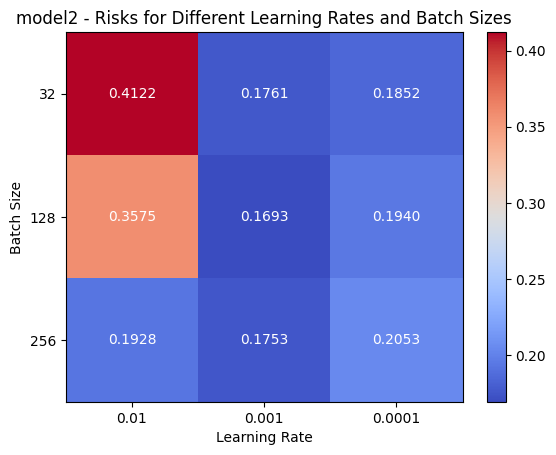

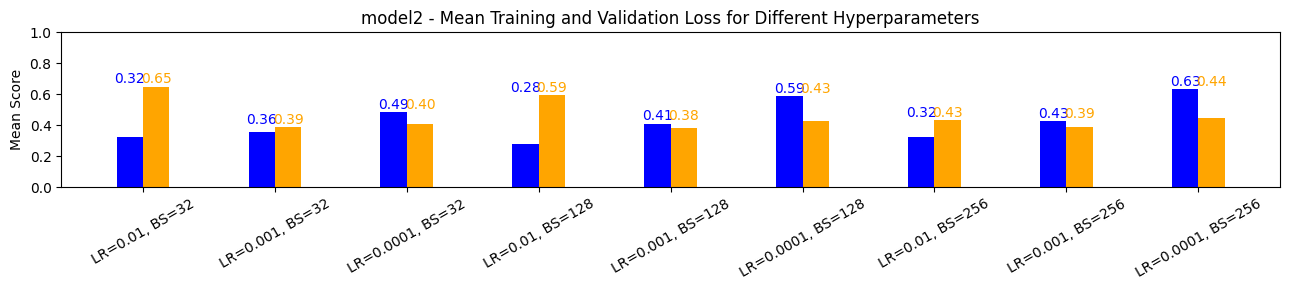

In [180]:
plot_risks_matrix(model2, model2_risks)
plot_training_validation_loss(model2, model2_train, model2_val)

In [181]:
model3_train, model3_val, model3_risks, model3_epochs = hyperparameter_test_cross_validation(model3)

model3 batch_size: 32 learning_rate: 0.01
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 10ms/step - loss: 0.7235 - accuracy: 0.5411 - val_loss: 0.6904 - val_accuracy: 0.5405
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6902 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy: 0.5405
Epoch 3/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6904 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy: 0.5405
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6905 - accuracy: 0.5407 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6902 - accuracy: 0.5407 - val_loss: 0.6900 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6902 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 7/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6901 - accuracy: 0.

148/148 [==============================] - 1s 9ms/step - loss: 0.2467 - accuracy: 0.8990 - val_loss: 0.3946 - val_accuracy: 0.8497
Fold 2/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6315 - accuracy: 0.6277 - val_loss: 0.5451 - val_accuracy: 0.7356
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4886 - accuracy: 0.7617 - val_loss: 0.4670 - val_accuracy: 0.7745
Epoch 3/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4505 - accuracy: 0.7980 - val_loss: 0.4308 - val_accuracy: 0.8007
Epoch 4/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4100 - accuracy: 0.8166 - val_loss: 0.4028 - val_accuracy: 0.8201
Epoch 5/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3875 - accuracy: 0.8208 - val_loss: 0.4007 - val_accuracy: 0.8150
Epoch 6/50
148/148 [==============================] - 2s 10ms/step - loss: 0.3518 - accuracy: 0.8462 - val_loss: 0.4056 - val_accuracy: 0.8091
Epoc

148/148 [==============================] - 1s 9ms/step - loss: 0.1826 - accuracy: 0.9271 - val_loss: 0.4575 - val_accuracy: 0.8309
risk estimate: 0.16359689235687255
model3 batch_size: 32 learning_rate: 0.0001
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6692 - accuracy: 0.5924 - val_loss: 0.6304 - val_accuracy: 0.7416
Epoch 2/50
148/148 [==============================] - 1s 10ms/step - loss: 0.5940 - accuracy: 0.7074 - val_loss: 0.5349 - val_accuracy: 0.7686
Epoch 3/50
148/148 [==============================] - 1s 10ms/step - loss: 0.5163 - accuracy: 0.7555 - val_loss: 0.5149 - val_accuracy: 0.7618
Epoch 4/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4846 - accuracy: 0.7746 - val_loss: 0.4818 - val_accuracy: 0.7838
Epoch 5/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4709 - accuracy: 0.7832 - val_loss: 0.4630 - val_accuracy: 0.7770
Epoch 6/50
148/148 [==============================] - 1s 9ms/step - 

Epoch 10/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4348 - accuracy: 0.8041 - val_loss: 0.4533 - val_accuracy: 0.7872
Epoch 11/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4333 - accuracy: 0.7993 - val_loss: 0.4480 - val_accuracy: 0.7863
Epoch 12/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4284 - accuracy: 0.8037 - val_loss: 0.4615 - val_accuracy: 0.7720
Epoch 13/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4201 - accuracy: 0.8105 - val_loss: 0.4410 - val_accuracy: 0.7939
Epoch 14/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4154 - accuracy: 0.8084 - val_loss: 0.4515 - val_accuracy: 0.7905
Epoch 15/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4112 - accuracy: 0.8113 - val_loss: 0.4365 - val_accuracy: 0.7998
Epoch 16/50
148/148 [==============================] - 1s 9ms/step - loss: 0.4091 - accuracy: 0.8136 - val_loss: 0.4386 - val_accuracy: 0.793

148/148 [==============================] - 1s 9ms/step - loss: 0.3885 - accuracy: 0.8221 - val_loss: 0.4342 - val_accuracy: 0.8030
Epoch 18/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3819 - accuracy: 0.8350 - val_loss: 0.4215 - val_accuracy: 0.8123
Epoch 19/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3804 - accuracy: 0.8262 - val_loss: 0.4132 - val_accuracy: 0.8183
Epoch 20/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3707 - accuracy: 0.8359 - val_loss: 0.4138 - val_accuracy: 0.8098
Epoch 21/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3670 - accuracy: 0.8363 - val_loss: 0.4130 - val_accuracy: 0.8107
Epoch 22/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3623 - accuracy: 0.8424 - val_loss: 0.4170 - val_accuracy: 0.8081
Epoch 23/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3535 - accuracy: 0.8466 - val_loss: 0.4139 - val_accuracy: 0.8073
Epoch 24

148/148 [==============================] - 1s 9ms/step - loss: 0.3849 - accuracy: 0.8323 - val_loss: 0.4214 - val_accuracy: 0.8030
Epoch 19/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3902 - accuracy: 0.8285 - val_loss: 0.4086 - val_accuracy: 0.8183
Epoch 20/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3773 - accuracy: 0.8357 - val_loss: 0.4029 - val_accuracy: 0.8259
Epoch 21/50
148/148 [==============================] - 2s 11ms/step - loss: 0.3778 - accuracy: 0.8354 - val_loss: 0.4028 - val_accuracy: 0.8292
Epoch 22/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3738 - accuracy: 0.8338 - val_loss: 0.3981 - val_accuracy: 0.8292
Epoch 23/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3645 - accuracy: 0.8428 - val_loss: 0.3941 - val_accuracy: 0.8326
Epoch 24/50
148/148 [==============================] - 1s 9ms/step - loss: 0.3580 - accuracy: 0.8462 - val_loss: 0.4065 - val_accuracy: 0.8132
Epoch 2

Epoch 6/50
37/37 [==============================] - 0s 12ms/step - loss: 0.5051 - accuracy: 0.7566 - val_loss: 0.4880 - val_accuracy: 0.7601
Epoch 7/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4757 - accuracy: 0.7826 - val_loss: 0.4734 - val_accuracy: 0.7753
Epoch 8/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4543 - accuracy: 0.7913 - val_loss: 0.4736 - val_accuracy: 0.7660
Epoch 9/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.7786 - val_loss: 0.4524 - val_accuracy: 0.7787
Epoch 10/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4269 - accuracy: 0.8050 - val_loss: 0.4404 - val_accuracy: 0.7838
Epoch 11/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4372 - accuracy: 0.7967 - val_loss: 0.4657 - val_accuracy: 0.7812
Epoch 12/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4295 - accuracy: 0.7997 - val_loss: 0.4709 - val_accuracy: 0.7677
Epoch 13/5

37/37 [==============================] - 1s 17ms/step - loss: 0.7461 - accuracy: 0.5986 - val_loss: 0.5924 - val_accuracy: 0.7084
Epoch 2/50
37/37 [==============================] - 0s 12ms/step - loss: 0.5624 - accuracy: 0.7127 - val_loss: 0.5209 - val_accuracy: 0.7498
Epoch 3/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5163 - accuracy: 0.7535 - val_loss: 0.5974 - val_accuracy: 0.6982
Epoch 4/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4954 - accuracy: 0.7630 - val_loss: 0.4983 - val_accuracy: 0.7532
Epoch 5/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4601 - accuracy: 0.7850 - val_loss: 0.4911 - val_accuracy: 0.7684
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4686 - accuracy: 0.7822 - val_loss: 0.4793 - val_accuracy: 0.7844
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4427 - accuracy: 0.7926 - val_loss: 0.5055 - val_accuracy: 0.7523
Epoch 8/50
37/37 [======

37/37 [==============================] - 0s 12ms/step - loss: 0.2999 - accuracy: 0.8745 - val_loss: 0.3694 - val_accuracy: 0.8370
Epoch 17/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2885 - accuracy: 0.8825 - val_loss: 0.4031 - val_accuracy: 0.8167
Epoch 18/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2714 - accuracy: 0.8908 - val_loss: 0.3749 - val_accuracy: 0.8353
Epoch 19/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2573 - accuracy: 0.8969 - val_loss: 0.3696 - val_accuracy: 0.8378
Epoch 20/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2421 - accuracy: 0.9047 - val_loss: 0.3663 - val_accuracy: 0.8421
Epoch 21/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2289 - accuracy: 0.9159 - val_loss: 0.3641 - val_accuracy: 0.8446
Epoch 22/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2243 - accuracy: 0.9134 - val_loss: 0.3640 - val_accuracy: 0.8395
Epoch 23/50
37/37 

Epoch 19/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2282 - accuracy: 0.9123 - val_loss: 0.4502 - val_accuracy: 0.8047
Epoch 20/50
37/37 [==============================] - 0s 11ms/step - loss: 0.2202 - accuracy: 0.9138 - val_loss: 0.3914 - val_accuracy: 0.8343
Epoch 21/50
37/37 [==============================] - 0s 11ms/step - loss: 0.2012 - accuracy: 0.9250 - val_loss: 0.4916 - val_accuracy: 0.7912
Epoch 22/50
37/37 [==============================] - 0s 12ms/step - loss: 0.1901 - accuracy: 0.9294 - val_loss: 0.4026 - val_accuracy: 0.8360
Fold 5/5
Epoch 1/50
37/37 [==============================] - 1s 17ms/step - loss: 0.6508 - accuracy: 0.6202 - val_loss: 0.5734 - val_accuracy: 0.7227
Epoch 2/50
37/37 [==============================] - 0s 12ms/step - loss: 0.5299 - accuracy: 0.7433 - val_loss: 0.4804 - val_accuracy: 0.7743
Epoch 3/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4825 - accuracy: 0.7733 - val_loss: 0.4531 - val_accuracy: 0.7980


37/37 [==============================] - 0s 12ms/step - loss: 0.4143 - accuracy: 0.8143 - val_loss: 0.4252 - val_accuracy: 0.7990
Epoch 28/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4125 - accuracy: 0.8149 - val_loss: 0.4359 - val_accuracy: 0.7956
Epoch 29/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4101 - accuracy: 0.8172 - val_loss: 0.4227 - val_accuracy: 0.8015
Epoch 30/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4107 - accuracy: 0.8181 - val_loss: 0.4232 - val_accuracy: 0.8015
Epoch 31/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4086 - accuracy: 0.8172 - val_loss: 0.4316 - val_accuracy: 0.7897
Epoch 32/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4036 - accuracy: 0.8213 - val_loss: 0.4209 - val_accuracy: 0.8024
Epoch 33/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4008 - accuracy: 0.8158 - val_loss: 0.4164 - val_accuracy: 0.8032
Epoch 34/50
37/37 

Epoch 35/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3929 - accuracy: 0.8299 - val_loss: 0.4487 - val_accuracy: 0.7821
Epoch 36/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3902 - accuracy: 0.8251 - val_loss: 0.4241 - val_accuracy: 0.8057
Epoch 37/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3950 - accuracy: 0.8253 - val_loss: 0.4315 - val_accuracy: 0.7931
Epoch 38/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3858 - accuracy: 0.8286 - val_loss: 0.4262 - val_accuracy: 0.7956
Epoch 39/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3875 - accuracy: 0.8265 - val_loss: 0.4217 - val_accuracy: 0.8032
Epoch 40/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3824 - accuracy: 0.8312 - val_loss: 0.4261 - val_accuracy: 0.8083
Epoch 41/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3796 - accuracy: 0.8329 - val_loss: 0.4318 - val_accuracy: 0.7897
Epoch 

Epoch 43/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3858 - accuracy: 0.8285 - val_loss: 0.4480 - val_accuracy: 0.7963
Epoch 44/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3797 - accuracy: 0.8308 - val_loss: 0.4319 - val_accuracy: 0.7997
Epoch 45/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3798 - accuracy: 0.8272 - val_loss: 0.4281 - val_accuracy: 0.8022
Epoch 46/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3787 - accuracy: 0.8316 - val_loss: 0.4322 - val_accuracy: 0.7997
Epoch 47/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3794 - accuracy: 0.8283 - val_loss: 0.4635 - val_accuracy: 0.7895
Epoch 48/50
37/37 [==============================] - 0s 12ms/step - loss: 0.3767 - accuracy: 0.8331 - val_loss: 0.4471 - val_accuracy: 0.7997
Epoch 49/50
37/37 [==============================] - 0s 13ms/step - loss: 0.3713 - accuracy: 0.8323 - val_loss: 0.4224 - val_accuracy: 0.8064
Epoch 

Fold 5/5
Epoch 1/50
37/37 [==============================] - 1s 18ms/step - loss: 0.6863 - accuracy: 0.5406 - val_loss: 0.6793 - val_accuracy: 0.5402
Epoch 2/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6726 - accuracy: 0.5507 - val_loss: 0.6630 - val_accuracy: 0.6974
Epoch 3/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6529 - accuracy: 0.6381 - val_loss: 0.6367 - val_accuracy: 0.6822
Epoch 4/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6268 - accuracy: 0.6962 - val_loss: 0.6063 - val_accuracy: 0.7194
Epoch 5/50
37/37 [==============================] - 0s 12ms/step - loss: 0.5932 - accuracy: 0.7241 - val_loss: 0.5712 - val_accuracy: 0.7599
Epoch 6/50
37/37 [==============================] - 0s 12ms/step - loss: 0.5621 - accuracy: 0.7484 - val_loss: 0.5528 - val_accuracy: 0.7312
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5336 - accuracy: 0.7537 - val_loss: 0.5125 - val_accuracy: 0.7718
Epoc

19/19 [==============================] - 0s 16ms/step - loss: 0.6900 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy: 0.5405
Epoch 9/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6901 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Fold 2/5
Epoch 1/50
19/19 [==============================] - 1s 26ms/step - loss: 0.7560 - accuracy: 0.5335 - val_loss: 0.6487 - val_accuracy: 0.6926
Epoch 2/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6120 - accuracy: 0.6729 - val_loss: 0.5721 - val_accuracy: 0.7052
Epoch 3/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5471 - accuracy: 0.7181 - val_loss: 0.5283 - val_accuracy: 0.7373
Epoch 4/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5121 - accuracy: 0.7509 - val_loss: 0.4858 - val_accuracy: 0.7720
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4704 - accuracy: 0.7853 - val_loss: 0.4828 - val_accuracy: 0.7728
Epoch 6/50
19/1

Epoch 12/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4326 - accuracy: 0.7978 - val_loss: 0.4577 - val_accuracy: 0.7853
Epoch 13/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4118 - accuracy: 0.8023 - val_loss: 0.4661 - val_accuracy: 0.7802
Epoch 14/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4264 - accuracy: 0.7970 - val_loss: 0.4765 - val_accuracy: 0.7735
Epoch 15/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4184 - accuracy: 0.8048 - val_loss: 0.4677 - val_accuracy: 0.7718
Epoch 16/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3824 - accuracy: 0.8238 - val_loss: 0.4586 - val_accuracy: 0.7929
Epoch 17/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3665 - accuracy: 0.8319 - val_loss: 0.4577 - val_accuracy: 0.7954
risk estimate: 0.3018402695655823
model3 batch_size: 256 learning_rate: 0.001
Fold 1/5
Epoch 1/50
19/19 [==============================] - 1s 26ms/s

19/19 [==============================] - 0s 15ms/step - loss: 0.3455 - accuracy: 0.8523 - val_loss: 0.3959 - val_accuracy: 0.8108
Epoch 20/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3317 - accuracy: 0.8563 - val_loss: 0.4000 - val_accuracy: 0.8159
Epoch 21/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3299 - accuracy: 0.8608 - val_loss: 0.3937 - val_accuracy: 0.8117
Epoch 22/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3177 - accuracy: 0.8677 - val_loss: 0.3896 - val_accuracy: 0.8150
Epoch 23/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3156 - accuracy: 0.8635 - val_loss: 0.4083 - val_accuracy: 0.8057
Epoch 24/50
19/19 [==============================] - 0s 16ms/step - loss: 0.2979 - accuracy: 0.8787 - val_loss: 0.3886 - val_accuracy: 0.8193
Epoch 25/50
19/19 [==============================] - 0s 16ms/step - loss: 0.2912 - accuracy: 0.8791 - val_loss: 0.3814 - val_accuracy: 0.8176
Epoch 26/50
19/19 

Epoch 14/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3713 - accuracy: 0.8333 - val_loss: 0.4396 - val_accuracy: 0.7997
Epoch 15/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3822 - accuracy: 0.8327 - val_loss: 0.4123 - val_accuracy: 0.8098
Epoch 16/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3493 - accuracy: 0.8504 - val_loss: 0.4060 - val_accuracy: 0.8199
Epoch 17/50
19/19 [==============================] - 0s 15ms/step - loss: 0.3542 - accuracy: 0.8439 - val_loss: 0.4002 - val_accuracy: 0.8233
Epoch 18/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3396 - accuracy: 0.8553 - val_loss: 0.3963 - val_accuracy: 0.8208
Epoch 19/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3359 - accuracy: 0.8553 - val_loss: 0.4006 - val_accuracy: 0.8064
Epoch 20/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3530 - accuracy: 0.8447 - val_loss: 0.4222 - val_accuracy: 0.8090
Epoch 

risk estimate: 0.16579270362854004
model3 batch_size: 256 learning_rate: 0.0001
Fold 1/5
Epoch 1/50
19/19 [==============================] - 1s 27ms/step - loss: 0.6833 - accuracy: 0.5466 - val_loss: 0.6748 - val_accuracy: 0.5921
Epoch 2/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6691 - accuracy: 0.5884 - val_loss: 0.6582 - val_accuracy: 0.5676
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6514 - accuracy: 0.6341 - val_loss: 0.6383 - val_accuracy: 0.6470
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.6308 - accuracy: 0.6820 - val_loss: 0.6169 - val_accuracy: 0.6723
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6105 - accuracy: 0.7040 - val_loss: 0.5926 - val_accuracy: 0.7323
Epoch 6/50
19/19 [==============================] - 0s 16ms/step - loss: 0.5859 - accuracy: 0.7228 - val_loss: 0.5701 - val_accuracy: 0.7500
Epoch 7/50
19/19 [==============================] - 0s 15ms/step 

19/19 [==============================] - 0s 16ms/step - loss: 0.5600 - accuracy: 0.7439 - val_loss: 0.5467 - val_accuracy: 0.7610
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss: 0.5379 - accuracy: 0.7583 - val_loss: 0.5284 - val_accuracy: 0.7584
Epoch 10/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5245 - accuracy: 0.7545 - val_loss: 0.5180 - val_accuracy: 0.7703
Epoch 11/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5160 - accuracy: 0.7627 - val_loss: 0.5188 - val_accuracy: 0.7601
Epoch 12/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5042 - accuracy: 0.7678 - val_loss: 0.4966 - val_accuracy: 0.7711
Epoch 13/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4916 - accuracy: 0.7771 - val_loss: 0.4937 - val_accuracy: 0.7635
Epoch 14/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4833 - accuracy: 0.7805 - val_loss: 0.4836 - val_accuracy: 0.7770
Epoch 15/50
19/19 [

Epoch 16/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4648 - accuracy: 0.7814 - val_loss: 0.4875 - val_accuracy: 0.7675
Epoch 17/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4623 - accuracy: 0.7873 - val_loss: 0.4804 - val_accuracy: 0.7819
Epoch 18/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4602 - accuracy: 0.7879 - val_loss: 0.4990 - val_accuracy: 0.7667
Epoch 19/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4619 - accuracy: 0.7852 - val_loss: 0.4857 - val_accuracy: 0.7726
Epoch 20/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4583 - accuracy: 0.7852 - val_loss: 0.4881 - val_accuracy: 0.7751
Epoch 21/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4561 - accuracy: 0.7883 - val_loss: 0.4720 - val_accuracy: 0.7844
Epoch 22/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4480 - accuracy: 0.7947 - val_loss: 0.4711 - val_accuracy: 0.7870
Epoch 

Epoch 24/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4469 - accuracy: 0.7936 - val_loss: 0.4594 - val_accuracy: 0.7946
Epoch 25/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4429 - accuracy: 0.8002 - val_loss: 0.4624 - val_accuracy: 0.7921
Epoch 26/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4402 - accuracy: 0.8035 - val_loss: 0.4536 - val_accuracy: 0.7997
Epoch 27/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4390 - accuracy: 0.8006 - val_loss: 0.4510 - val_accuracy: 0.7895
Epoch 28/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4343 - accuracy: 0.8023 - val_loss: 0.4570 - val_accuracy: 0.7929
Epoch 29/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4355 - accuracy: 0.8029 - val_loss: 0.4479 - val_accuracy: 0.7895
Epoch 30/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4299 - accuracy: 0.8057 - val_loss: 0.4466 - val_accuracy: 0.7904
Epoch 

Epoch 32/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4300 - accuracy: 0.8048 - val_loss: 0.4458 - val_accuracy: 0.7861
Epoch 33/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4316 - accuracy: 0.8048 - val_loss: 0.4338 - val_accuracy: 0.8022
Epoch 34/50
19/19 [==============================] - 0s 17ms/step - loss: 0.4306 - accuracy: 0.8046 - val_loss: 0.4305 - val_accuracy: 0.8005
Epoch 35/50
19/19 [==============================] - 0s 17ms/step - loss: 0.4285 - accuracy: 0.8065 - val_loss: 0.4336 - val_accuracy: 0.8081
Epoch 36/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4222 - accuracy: 0.8086 - val_loss: 0.4377 - val_accuracy: 0.7929
Epoch 37/50
19/19 [==============================] - 0s 17ms/step - loss: 0.4218 - accuracy: 0.8116 - val_loss: 0.4269 - val_accuracy: 0.8056
Epoch 38/50
19/19 [==============================] - 0s 17ms/step - loss: 0.4190 - accuracy: 0.8141 - val_loss: 0.4292 - val_accuracy: 0.8039
Epoch 

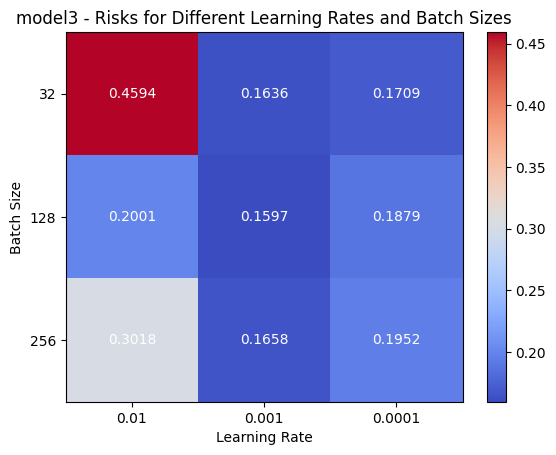

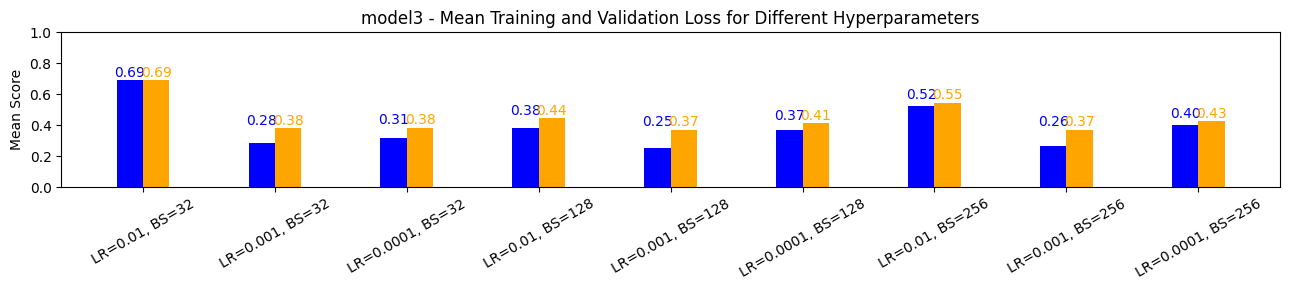

In [182]:
plot_risks_matrix(model3, model3_risks)
plot_training_validation_loss(model3, model3_train, model3_val)

In [183]:
model4_train, model4_val, model4_risks, model4_epochs = hyperparameter_test_cross_validation(model4)

model4 batch_size: 32 learning_rate: 0.01
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6931 - accuracy: 0.5398 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 2/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6905 - accuracy: 0.5407 - val_loss: 0.6902 - val_accuracy: 0.5405
Epoch 3/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6902 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Epoch 4/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6899 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy: 0.5405
Epoch 5/50
148/148 [==============================] - 2s 10ms/step - loss: 0.6901 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy: 0.5405
Epoch 6/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6902 - accuracy: 0.5407 - val_loss: 0.6899 - val_accuracy: 0.5405
Fold 2/5
Epoch 1/50
148/148 [==============================] - 3s 12ms/step - loss: 0.6925 -

148/148 [==============================] - 2s 11ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6899 - val_accuracy: 0.5402
Epoch 6/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6900 - accuracy: 0.5408 - val_loss: 0.6900 - val_accuracy: 0.5402
Epoch 7/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6903 - val_accuracy: 0.5402
Epoch 8/50
148/148 [==============================] - 2s 10ms/step - loss: 0.6902 - accuracy: 0.5408 - val_loss: 0.6901 - val_accuracy: 0.5402
risk estimate: 0.424189555644989
model4 batch_size: 32 learning_rate: 0.001
Fold 1/5
Epoch 1/50
148/148 [==============================] - 2s 12ms/step - loss: 0.6571 - accuracy: 0.5996 - val_loss: 0.5492 - val_accuracy: 0.7475
Epoch 2/50
148/148 [==============================] - 2s 10ms/step - loss: 0.5212 - accuracy: 0.7437 - val_loss: 0.4758 - val_accuracy: 0.7796
Epoch 3/50
148/148 [==============================] - 2s 10ms/step -

148/148 [==============================] - 2s 10ms/step - loss: 0.2973 - accuracy: 0.8745 - val_loss: 0.4047 - val_accuracy: 0.8216
Epoch 10/50
148/148 [==============================] - 1s 10ms/step - loss: 0.2750 - accuracy: 0.8906 - val_loss: 0.4289 - val_accuracy: 0.8123
Epoch 11/50
148/148 [==============================] - 2s 10ms/step - loss: 0.2636 - accuracy: 0.8910 - val_loss: 0.3955 - val_accuracy: 0.8343
Epoch 12/50
148/148 [==============================] - 2s 11ms/step - loss: 0.2232 - accuracy: 0.9090 - val_loss: 0.4568 - val_accuracy: 0.8047
Epoch 13/50
148/148 [==============================] - 2s 11ms/step - loss: 0.1904 - accuracy: 0.9252 - val_loss: 0.4494 - val_accuracy: 0.8174
Fold 5/5
Epoch 1/50
148/148 [==============================] - 3s 12ms/step - loss: 0.6325 - accuracy: 0.6257 - val_loss: 0.4887 - val_accuracy: 0.7785
Epoch 2/50
148/148 [==============================] - 1s 10ms/step - loss: 0.5143 - accuracy: 0.7573 - val_loss: 0.4665 - val_accuracy: 0.79

148/148 [==============================] - 2s 11ms/step - loss: 0.3462 - accuracy: 0.8483 - val_loss: 0.3739 - val_accuracy: 0.8345
Epoch 40/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3403 - accuracy: 0.8555 - val_loss: 0.3722 - val_accuracy: 0.8302
Epoch 41/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3334 - accuracy: 0.8601 - val_loss: 0.3680 - val_accuracy: 0.8387
Epoch 42/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3335 - accuracy: 0.8574 - val_loss: 0.3966 - val_accuracy: 0.8243
Epoch 43/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3302 - accuracy: 0.8629 - val_loss: 0.3755 - val_accuracy: 0.8345
Epoch 44/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3262 - accuracy: 0.8608 - val_loss: 0.3735 - val_accuracy: 0.8294
Epoch 45/50
148/148 [==============================] - 1s 10ms/step - loss: 0.3172 - accuracy: 0.8682 - val_loss: 0.3838 - val_accuracy: 0.8353
Epoc

Epoch 8/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4759 - accuracy: 0.7757 - val_loss: 0.4931 - val_accuracy: 0.7726
Epoch 9/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4686 - accuracy: 0.7837 - val_loss: 0.4995 - val_accuracy: 0.7667
Epoch 10/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4607 - accuracy: 0.7866 - val_loss: 0.5162 - val_accuracy: 0.7667
Epoch 11/50
148/148 [==============================] - 2s 11ms/step - loss: 0.4575 - accuracy: 0.7850 - val_loss: 0.4754 - val_accuracy: 0.7743
Epoch 12/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4518 - accuracy: 0.7907 - val_loss: 0.4725 - val_accuracy: 0.7726
Epoch 13/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4511 - accuracy: 0.7940 - val_loss: 0.4695 - val_accuracy: 0.7836
Epoch 14/50
148/148 [==============================] - 1s 10ms/step - loss: 0.4478 - accuracy: 0.7940 - val_loss: 0.4697 - val_accuracy: 0

Epoch 16/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4234 - accuracy: 0.8118 - val_loss: 0.4379 - val_accuracy: 0.7946
Epoch 17/50
148/148 [==============================] - 2s 11ms/step - loss: 0.4171 - accuracy: 0.8101 - val_loss: 0.4348 - val_accuracy: 0.7963
Epoch 18/50
148/148 [==============================] - 2s 10ms/step - loss: 0.4171 - accuracy: 0.8114 - val_loss: 0.4413 - val_accuracy: 0.7895
Epoch 19/50
148/148 [==============================] - 2s 11ms/step - loss: 0.4073 - accuracy: 0.8145 - val_loss: 0.4581 - val_accuracy: 0.7853
Epoch 20/50
148/148 [==============================] - 2s 11ms/step - loss: 0.4074 - accuracy: 0.8147 - val_loss: 0.4299 - val_accuracy: 0.7988
Epoch 21/50
148/148 [==============================] - 2s 12ms/step - loss: 0.4032 - accuracy: 0.8232 - val_loss: 0.4298 - val_accuracy: 0.8030
Epoch 22/50
148/148 [==============================] - 2s 11ms/step - loss: 0.3962 - accuracy: 0.8190 - val_loss: 0.4806 - val_accuracy:

37/37 [==============================] - 0s 11ms/step - loss: 0.5879 - accuracy: 0.6894 - val_loss: 0.5615 - val_accuracy: 0.7120
Epoch 8/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5762 - accuracy: 0.6886 - val_loss: 0.5916 - val_accuracy: 0.6875
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5530 - accuracy: 0.7097 - val_loss: 0.5335 - val_accuracy: 0.7238
Epoch 10/50
37/37 [==============================] - 0s 11ms/step - loss: 0.5115 - accuracy: 0.7401 - val_loss: 0.5339 - val_accuracy: 0.7230
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4922 - accuracy: 0.7560 - val_loss: 0.5097 - val_accuracy: 0.7508
Epoch 12/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4818 - accuracy: 0.7676 - val_loss: 0.5645 - val_accuracy: 0.7238
Epoch 13/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4801 - accuracy: 0.7705 - val_loss: 0.5176 - val_accuracy: 0.7492
Epoch 14/50
37/37 [=

Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4277 - accuracy: 0.8006 - val_loss: 0.4156 - val_accuracy: 0.8098
Epoch 12/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4159 - accuracy: 0.8067 - val_loss: 0.5022 - val_accuracy: 0.7650
Epoch 13/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4102 - accuracy: 0.8128 - val_loss: 0.4839 - val_accuracy: 0.7658
Epoch 14/50
37/37 [==============================] - 0s 11ms/step - loss: 0.4171 - accuracy: 0.8133 - val_loss: 0.4543 - val_accuracy: 0.7853
Epoch 15/50
37/37 [==============================] - 0s 10ms/step - loss: 0.3950 - accuracy: 0.8230 - val_loss: 0.4354 - val_accuracy: 0.8039
Epoch 16/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3661 - accuracy: 0.8380 - val_loss: 0.4097 - val_accuracy: 0.8208
Epoch 17/50
37/37 [==============================] - 0s 11ms/step - loss: 0.3736 - accuracy: 0.8338 - val_loss: 0.4440 - val_accuracy: 0.7980
Epoch 

37/37 [==============================] - 0s 12ms/step - loss: 0.3031 - accuracy: 0.8724 - val_loss: 0.3943 - val_accuracy: 0.8243
Epoch 22/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2629 - accuracy: 0.8999 - val_loss: 0.3918 - val_accuracy: 0.8260
Epoch 23/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2517 - accuracy: 0.9024 - val_loss: 0.4174 - val_accuracy: 0.8133
Epoch 24/50
37/37 [==============================] - 0s 11ms/step - loss: 0.2449 - accuracy: 0.9043 - val_loss: 0.4144 - val_accuracy: 0.8252
Epoch 25/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2277 - accuracy: 0.9079 - val_loss: 0.3998 - val_accuracy: 0.8235
Epoch 26/50
37/37 [==============================] - 0s 11ms/step - loss: 0.2171 - accuracy: 0.9174 - val_loss: 0.4893 - val_accuracy: 0.8125
Epoch 27/50
37/37 [==============================] - 0s 12ms/step - loss: 0.2075 - accuracy: 0.9239 - val_loss: 0.4041 - val_accuracy: 0.8319
Fold 3/5
Epoch 1/5

Epoch 6/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4677 - accuracy: 0.7812 - val_loss: 0.4500 - val_accuracy: 0.8005
Epoch 7/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4415 - accuracy: 0.7987 - val_loss: 0.4751 - val_accuracy: 0.7743
Epoch 8/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4265 - accuracy: 0.8109 - val_loss: 0.4343 - val_accuracy: 0.8047
Epoch 9/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4087 - accuracy: 0.8141 - val_loss: 0.4389 - val_accuracy: 0.7963
Epoch 10/50
37/37 [==============================] - 0s 13ms/step - loss: 0.3999 - accuracy: 0.8232 - val_loss: 0.4992 - val_accuracy: 0.7599
Epoch 11/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4098 - accuracy: 0.8107 - val_loss: 0.4223 - val_accuracy: 0.8174
Epoch 12/50
37/37 [==============================] - 0s 13ms/step - loss: 0.3770 - accuracy: 0.8333 - val_loss: 0.4149 - val_accuracy: 0.8183
Epoch 13/5

37/37 [==============================] - 0s 13ms/step - loss: 0.4109 - accuracy: 0.8172 - val_loss: 0.4217 - val_accuracy: 0.8108
Epoch 44/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4093 - accuracy: 0.8181 - val_loss: 0.4218 - val_accuracy: 0.8159
Epoch 45/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4096 - accuracy: 0.8204 - val_loss: 0.4211 - val_accuracy: 0.8100
Epoch 46/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4078 - accuracy: 0.8191 - val_loss: 0.4180 - val_accuracy: 0.8159
Epoch 47/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4029 - accuracy: 0.8223 - val_loss: 0.4211 - val_accuracy: 0.8117
Epoch 48/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4089 - accuracy: 0.8179 - val_loss: 0.4315 - val_accuracy: 0.7965
Epoch 49/50
37/37 [==============================] - 0s 13ms/step - loss: 0.4029 - accuracy: 0.8208 - val_loss: 0.4130 - val_accuracy: 0.8150
Epoch 50/50
37/37 

Fold 3/5
Epoch 1/50
37/37 [==============================] - 1s 18ms/step - loss: 0.6874 - accuracy: 0.5408 - val_loss: 0.6858 - val_accuracy: 0.5410
Epoch 2/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6825 - accuracy: 0.5408 - val_loss: 0.6813 - val_accuracy: 0.5427
Epoch 3/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6757 - accuracy: 0.5444 - val_loss: 0.6726 - val_accuracy: 0.5562
Epoch 4/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6619 - accuracy: 0.5843 - val_loss: 0.6572 - val_accuracy: 0.6695
Epoch 5/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6407 - accuracy: 0.6694 - val_loss: 0.6364 - val_accuracy: 0.6932
Epoch 6/50
37/37 [==============================] - 0s 12ms/step - loss: 0.6117 - accuracy: 0.7112 - val_loss: 0.6078 - val_accuracy: 0.6948
Epoch 7/50
37/37 [==============================] - 0s 13ms/step - loss: 0.5788 - accuracy: 0.7338 - val_loss: 0.5800 - val_accuracy: 0.7058
Epoc

Epoch 17/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4712 - accuracy: 0.7805 - val_loss: 0.5625 - val_accuracy: 0.7067
Epoch 18/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4726 - accuracy: 0.7809 - val_loss: 0.4710 - val_accuracy: 0.7828
Epoch 19/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4536 - accuracy: 0.7949 - val_loss: 0.4662 - val_accuracy: 0.7836
Epoch 20/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4498 - accuracy: 0.7962 - val_loss: 0.4652 - val_accuracy: 0.7785
Epoch 21/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4462 - accuracy: 0.7976 - val_loss: 0.4625 - val_accuracy: 0.7870
Epoch 22/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4430 - accuracy: 0.7997 - val_loss: 0.4643 - val_accuracy: 0.7811
Epoch 23/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4429 - accuracy: 0.7955 - val_loss: 0.4575 - val_accuracy: 0.7828
Epoch 

Epoch 25/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4539 - accuracy: 0.7913 - val_loss: 0.4927 - val_accuracy: 0.7591
Epoch 26/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4536 - accuracy: 0.7926 - val_loss: 0.4570 - val_accuracy: 0.7946
Epoch 27/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4488 - accuracy: 0.7947 - val_loss: 0.4561 - val_accuracy: 0.7971
Epoch 28/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4488 - accuracy: 0.7959 - val_loss: 0.4495 - val_accuracy: 0.8022
Epoch 29/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4408 - accuracy: 0.7997 - val_loss: 0.4554 - val_accuracy: 0.7878
Epoch 30/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4364 - accuracy: 0.8023 - val_loss: 0.4484 - val_accuracy: 0.7963
Epoch 31/50
37/37 [==============================] - 0s 12ms/step - loss: 0.4361 - accuracy: 0.8023 - val_loss: 0.4442 - val_accuracy: 0.8064
Epoch 

19/19 [==============================] - 0s 14ms/step - loss: 0.4577 - accuracy: 0.7847 - val_loss: 0.4487 - val_accuracy: 0.7905
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4370 - accuracy: 0.8018 - val_loss: 0.4432 - val_accuracy: 0.8007
Epoch 11/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4472 - accuracy: 0.7898 - val_loss: 0.5080 - val_accuracy: 0.7627
Epoch 12/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4857 - accuracy: 0.7655 - val_loss: 0.4671 - val_accuracy: 0.7736
Epoch 13/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4490 - accuracy: 0.7910 - val_loss: 0.4844 - val_accuracy: 0.7652
Epoch 14/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4430 - accuracy: 0.7976 - val_loss: 0.4648 - val_accuracy: 0.7787
Epoch 15/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4314 - accuracy: 0.8025 - val_loss: 0.4691 - val_accuracy: 0.7762
Fold 3/5
Epoch 1/5

Epoch 6/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6466 - accuracy: 0.6063 - val_loss: 0.6006 - val_accuracy: 0.6839
Epoch 7/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6135 - accuracy: 0.6534 - val_loss: 0.6027 - val_accuracy: 0.6796
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6035 - accuracy: 0.6603 - val_loss: 0.5985 - val_accuracy: 0.6839
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5877 - accuracy: 0.6823 - val_loss: 0.5565 - val_accuracy: 0.7295
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5710 - accuracy: 0.6967 - val_loss: 0.5606 - val_accuracy: 0.7160
Epoch 11/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5589 - accuracy: 0.7022 - val_loss: 0.5588 - val_accuracy: 0.7151
Epoch 12/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5457 - accuracy: 0.7159 - val_loss: 0.5580 - val_accuracy: 0.7058
Epoch 13/5

19/19 [==============================] - 0s 15ms/step - loss: 0.5067 - accuracy: 0.7583 - val_loss: 0.5671 - val_accuracy: 0.7044
Epoch 5/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5101 - accuracy: 0.7522 - val_loss: 0.5256 - val_accuracy: 0.7424
Epoch 6/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4764 - accuracy: 0.7782 - val_loss: 0.5141 - val_accuracy: 0.7492
Epoch 7/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4648 - accuracy: 0.7796 - val_loss: 0.5156 - val_accuracy: 0.7508
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4761 - accuracy: 0.7686 - val_loss: 0.4783 - val_accuracy: 0.7618
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss: 0.4412 - accuracy: 0.7970 - val_loss: 0.4932 - val_accuracy: 0.7542
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4643 - accuracy: 0.7748 - val_loss: 0.4801 - val_accuracy: 0.7576
Epoch 11/50
19/19 [====

Epoch 8/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4598 - accuracy: 0.7860 - val_loss: 0.4986 - val_accuracy: 0.7506
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4458 - accuracy: 0.7894 - val_loss: 0.4505 - val_accuracy: 0.7980
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4334 - accuracy: 0.8025 - val_loss: 0.4455 - val_accuracy: 0.7980
Epoch 11/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4317 - accuracy: 0.7970 - val_loss: 0.4431 - val_accuracy: 0.8014
Epoch 12/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4203 - accuracy: 0.8040 - val_loss: 0.4447 - val_accuracy: 0.7904
Epoch 13/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4171 - accuracy: 0.8145 - val_loss: 0.4548 - val_accuracy: 0.7811
Epoch 14/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4203 - accuracy: 0.8158 - val_loss: 0.4369 - val_accuracy: 0.7904
Epoch 15

Epoch 39/50
19/19 [==============================] - 0s 13ms/step - loss: 0.2047 - accuracy: 0.9187 - val_loss: 0.4289 - val_accuracy: 0.8191
risk estimate: 0.16917279958724976
model4 batch_size: 256 learning_rate: 0.0001
Fold 1/5
Epoch 1/50
19/19 [==============================] - 1s 25ms/step - loss: 0.6899 - accuracy: 0.5379 - val_loss: 0.6875 - val_accuracy: 0.5405
Epoch 2/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6870 - accuracy: 0.5407 - val_loss: 0.6855 - val_accuracy: 0.5405
Epoch 3/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6846 - accuracy: 0.5407 - val_loss: 0.6829 - val_accuracy: 0.5405
Epoch 4/50
19/19 [==============================] - 0s 13ms/step - loss: 0.6818 - accuracy: 0.5407 - val_loss: 0.6795 - val_accuracy: 0.5405
Epoch 5/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6785 - accuracy: 0.5407 - val_loss: 0.6748 - val_accuracy: 0.5405
Epoch 6/50
19/19 [==============================] - 0s 14ms/step

19/19 [==============================] - 0s 14ms/step - loss: 0.6681 - accuracy: 0.5633 - val_loss: 0.6643 - val_accuracy: 0.5938
Epoch 8/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6572 - accuracy: 0.6000 - val_loss: 0.6535 - val_accuracy: 0.6993
Epoch 9/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6439 - accuracy: 0.6562 - val_loss: 0.6353 - val_accuracy: 0.6782
Epoch 10/50
19/19 [==============================] - 0s 14ms/step - loss: 0.6261 - accuracy: 0.6797 - val_loss: 0.6142 - val_accuracy: 0.7213
Epoch 11/50
19/19 [==============================] - 0s 15ms/step - loss: 0.6078 - accuracy: 0.7105 - val_loss: 0.5958 - val_accuracy: 0.7407
Epoch 12/50
19/19 [==============================] - 0s 15ms/step - loss: 0.5847 - accuracy: 0.7334 - val_loss: 0.5705 - val_accuracy: 0.7492
Epoch 13/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5607 - accuracy: 0.7494 - val_loss: 0.5495 - val_accuracy: 0.7559
Epoch 14/50
19/19 [=

Epoch 15/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5287 - accuracy: 0.7564 - val_loss: 0.5388 - val_accuracy: 0.7380
Epoch 16/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5163 - accuracy: 0.7592 - val_loss: 0.5340 - val_accuracy: 0.7329
Epoch 17/50
19/19 [==============================] - 0s 14ms/step - loss: 0.5070 - accuracy: 0.7655 - val_loss: 0.5257 - val_accuracy: 0.7405
Epoch 18/50
19/19 [==============================] - 0s 13ms/step - loss: 0.5017 - accuracy: 0.7632 - val_loss: 0.5315 - val_accuracy: 0.7439
Epoch 19/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4976 - accuracy: 0.7638 - val_loss: 0.5191 - val_accuracy: 0.7464
Epoch 20/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4934 - accuracy: 0.7706 - val_loss: 0.5117 - val_accuracy: 0.7566
Epoch 21/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4925 - accuracy: 0.7674 - val_loss: 0.5119 - val_accuracy: 0.7532
Epoch 

Epoch 23/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4701 - accuracy: 0.7847 - val_loss: 0.4896 - val_accuracy: 0.7625
Epoch 24/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4768 - accuracy: 0.7795 - val_loss: 0.4817 - val_accuracy: 0.7658
Epoch 25/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4645 - accuracy: 0.7862 - val_loss: 0.4796 - val_accuracy: 0.7718
Epoch 26/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4667 - accuracy: 0.7875 - val_loss: 0.4774 - val_accuracy: 0.7802
Epoch 27/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4611 - accuracy: 0.7883 - val_loss: 0.4761 - val_accuracy: 0.7794
Epoch 28/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.7907 - val_loss: 0.4724 - val_accuracy: 0.7819
Epoch 29/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4580 - accuracy: 0.7907 - val_loss: 0.4829 - val_accuracy: 0.7667
Epoch 

Epoch 31/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4588 - accuracy: 0.7896 - val_loss: 0.4772 - val_accuracy: 0.7811
Epoch 32/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4616 - accuracy: 0.7866 - val_loss: 0.4605 - val_accuracy: 0.7844
Epoch 33/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4555 - accuracy: 0.7898 - val_loss: 0.4658 - val_accuracy: 0.7828
Epoch 34/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4527 - accuracy: 0.7896 - val_loss: 0.4563 - val_accuracy: 0.7878
Epoch 35/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4470 - accuracy: 0.7964 - val_loss: 0.4573 - val_accuracy: 0.7887
Epoch 36/50
19/19 [==============================] - 0s 13ms/step - loss: 0.4485 - accuracy: 0.7940 - val_loss: 0.4532 - val_accuracy: 0.7912
Epoch 37/50
19/19 [==============================] - 0s 14ms/step - loss: 0.4444 - accuracy: 0.7983 - val_loss: 0.4517 - val_accuracy: 0.7887
Epoch 

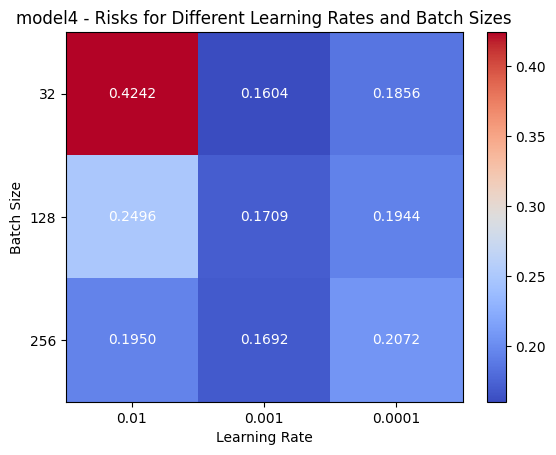

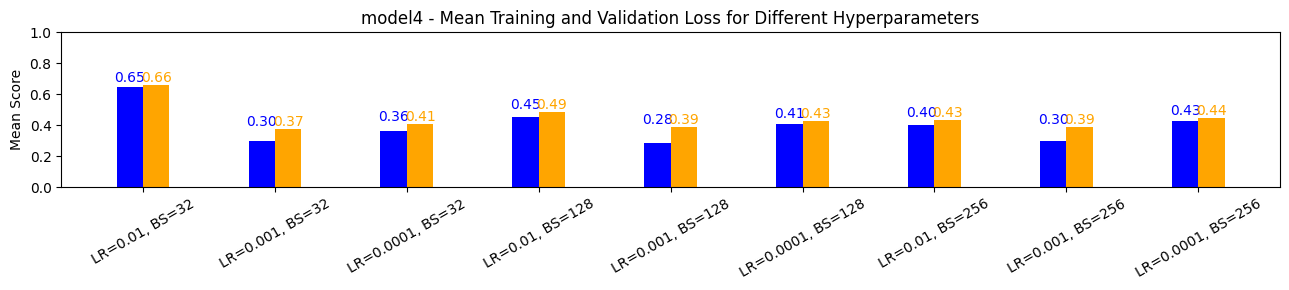

In [184]:
plot_risks_matrix(model4, model4_risks)
plot_training_validation_loss(model4, model4_train, model4_val)

In [188]:
models = [model1, model2, model3, model4]
risks = [model1_risks, model2_risks, model3_risks, model4_risks]
epochs = [model1_epochs, model2_epochs, model3_epochs, model4_epochs]

write_csv(models, risks, epochs)

IndexError: invalid index to scalar variable.

In [190]:
model1_epochs

13.8